## Data Preparation

Mempersiapkan dan memastikan bahwa data yang digunakan untuk analisis adalah data yang berkualitas dan dapat digunakan untuk modelling

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

df = pd.read_csv('train.csv', sep = ';')
df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
17257,32,technician,married,secondary,no,659,no,yes,cellular,28,jul,446,2,-1,0,unknown,no
32029,59,technician,married,secondary,no,0,yes,no,cellular,14,apr,145,1,-1,0,unknown,no
33704,35,management,single,tertiary,no,704,no,no,cellular,21,apr,164,1,-1,0,unknown,yes
34564,41,blue-collar,divorced,secondary,no,257,yes,no,cellular,5,may,442,2,-1,0,unknown,no
39598,43,management,divorced,tertiary,no,36,no,no,cellular,26,may,118,1,102,2,failure,no


In [2]:
cats = df.select_dtypes(include = ['object']).columns
nums = df.select_dtypes(include = ['int64', 'float64']).columns

cats, nums

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'poutcome', 'y'],
       dtype='object'),
 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'))

### Missing Values

In [136]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Tidak perlu handling missing values, dikarenakan tidak ada kolom yang null

### Duplicate Values

In [137]:
df.duplicated().any()

False

Tidak perlu handling duplicated values di karenakan tidak ada value duplikat

### Penanganan Outliers 

Kami mempertimbangkan untuk  penanganan outliers menggunakan Z-score untuk menentukan seberapa jauh suatu data berada dari rata-rata, dengan Z-score tinggi dianggap sebagai outlier atau nilai ekstrem , kami mempertimbangkan dengan memilih z-score dikarenakan kami tidak ingin kehilangan banyak data. Dikarenakan data nya tidak berdistribusi normal maka kami melakukan log transformasi terlebih dahulu.

In [3]:
for i in nums:
    if (df[i] < 0).any():
        print(f'{i} contains {len(df[df[i] < 0])} negative values')

balance contains 3766 negative values
pdays contains 36954 negative values


Fitur balance dan pdays dengan nilai negatif akan kami substitusi dengan nilai 0 atas penilaian nasabah tidak memiliki saldo dalam rekening dan nasabah belum pernah dikontak atau diberikan marketing campaign sebelumnya 

In [458]:
for i in nums:
    if (df[i] < 0).any():
        df[i] = df.apply(lambda x : int(0) if int(x[i]) < 0 else x[i], axis = 1)
    print(f"Total negative value of {i}:", (df[i] < 0).sum())

Total negative value of age: 0
Total negative value of balance: 0
Total negative value of day: 0
Total negative value of duration: 0
Total negative value of campaign: 0
Total negative value of pdays: 0
Total negative value of previous: 0


Sebelum melakukan log transformasi, dicek terlebih dahulu agar tidak ada negatif values ketika log transformasi

In [459]:
for i in nums:
    if i not in ['age', 'day']:
        df[i] = np.log(df[i] + (df[df[i] > 0][i].min() / 2))

Log transform diaplikasikan pada seluruh kolom numeric dengan mayoritas distribusi data positively skewed kecuali fitur age dan day dimana distribusi data cukup normal

In [140]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,5.199427,15.806419,5.167016,0.963267,0.389388,-0.373537
std,10.618762,3.007085,8.322476,0.927908,0.590519,2.311494,0.727591
min,18.000000,-0.693147,1.000000,-0.693147,0.405465,-0.693147,-0.693147
25%,33.000000,4.283587,8.000000,4.639572,0.405465,-0.693147,-0.693147
50%,39.000000,6.105909,16.000000,5.195731,0.916291,-0.693147,-0.693147
75%,48.000000,7.264380,21.000000,5.766757,1.252763,-0.693147,-0.693147
max,95.000000,11.533977,31.000000,8.500759,4.151040,6.770216,5.618588


Terlihat dari `df.describe()` bahwa data sudah berdistribusi normal

In [460]:
from scipy import stats

print("Before removing outlier: ", len(df))

for i in nums:
    if i not in ['age', 'day']:
        z_scores = np.abs(stats.zscore(df[i]))
        df = df[z_scores <= 3]

print("After removing outlier: ", len(df))

Before removing outlier:  45211
After removing outlier:  43173


Setelah removing outlier dengan zscore terdapat 2.038 data yang di remove

### Normalization Transformation

Seebelum dilakukan scalling dengan normalization, data perlu di split terlebih dahulu, menjadi train dan test

In [461]:
X = df.drop(columns=['y']).copy()
y = df[['y']].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [462]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for i in list(X_train.select_dtypes(include = ['int64', 'float64']).columns):
    fitted = scaler.fit(X_train[[i]])
    X_train[i] = fitted.transform(X_train[[i]])
    X_test[i] = fitted.transform(X_test[[i]])

Drop fitur education dengan unknown value karena kurang dapat memberikan informasi dan hanya mencakup 4.1% dari samples

In [32]:
for i in ['education']:
    if len(df[df[i].isin(['unknown'])]) > 0:
        print(f"{i} unknown: {round(len(df[df[i].isin(['unknown'])]) / len(df) * 100, 2)}%")

education unknown: 4.1%


In [463]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train = train[train['education'] != 'unknown']
test = test[test['education'] != 'unknown']
train = train[train['job'] != 'unknown']
test = test[test['job'] != 'unknown']

X_train = train.drop(columns=['y'])
y_train = train[['y']]

X_test = test.drop(columns=['y'])
y_test = test[['y']]

### Lable Encoding & One Hot Encoding

Fitur-fitur kategorikal perlu di-encode menjadi representasi numerik agar dapat digunakan dalam model. dengan label encoding pada kolom `education`, `default`, `housing`, `loan` dan `month`. untuk kolom month di jadikan 4 kuartal menjadi 'month quarter'
dan one hot encoding untuk kolom `job` dan `month quarter`

In [36]:
df[['pdays', 'previous']].corr()

,pdays,previous
pdays,1.000000,0.946205
previous,0.946205,1.000000


Antara kolom pdays dan previous rentan terjadi multicollinearity sehingga perlu ditentukan salah satu untuk menjadi fitur penentu

In [464]:
X_train['is_married'] = X_train['marital'].apply(lambda x : 1 if x == 'married' else 0)

X_test['is_married'] = X_test['marital'].apply(lambda x : 1 if x == 'married' else 0)

X_train['education_mapped'] = X_train['education'].map({'primary' : 0,
                                                        'secondary' : 1,
                                                        'tertiary' : 2})

X_test['education_mapped'] = X_test['education'].map({'primary' : 0,
                                                      'secondary' : 1,
                                                      'tertiary' : 2})

X_train['is_default'] = X_train['default'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_default'] = X_test['default'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_housing'] = X_train['housing'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_housing'] = X_test['housing'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_loan'] = X_train['loan'].map({'no' : 0,
                                          'yes' : 1})

X_test['is_loan'] = X_test['loan'].map({'no' : 0,
                                        'yes' : 1})

X_train['is_poutcome_succcess'] = X_train['poutcome'].apply(lambda x : 1 if x == 'success' else 0)

X_test['is_poutcome_succcess'] = X_test['poutcome'].apply(lambda x : 1 if x == 'success' else 0)

y_train['y'] = y_train['y'].map({'no' : 0,
                                 'yes' : 1})

y_test['y'] = y_test['y'].map({'no' : 0,
                               'yes' : 1})

In [465]:
for i in ['job']:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[i], prefix = i)], axis = 1)
    X_test = pd.concat([X_test, pd.get_dummies(X_test[i], prefix = i)], axis = 1)

In [364]:
X_train = X_train.drop(columns = list(X_train.select_dtypes(include = ['object']).columns) +\
                       ['contact', 'day', 'month', 'duration', 'campaign', 'pdays'])
X_test = X_test.drop(columns = list(X_test.select_dtypes(include = ['object']).columns) +\
                     ['contact', 'day', 'month', 'duration', 'campaign', 'pdays'])

In [331]:
X_train.columns, display(len(X_train.columns))

20

(Index(['age', 'balance', 'previous', 'is_married', 'education_mapped',
        'is_default', 'is_housing', 'is_loan', 'is_poutcome_succcess',
        'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
        'job_management', 'job_retired', 'job_self-employed', 'job_services',
        'job_student', 'job_technician', 'job_unemployed'],
       dtype='object'),
 None)

### Class Imbalance

In [365]:
from imblearn import over_sampling

X_train_over, y_train_over = over_sampling.SMOTE().fit_resample(X_train, y_train)

In [366]:
len(X_train_over), len(y_train_over), len(X_train), len(y_train), len(X_test), len(y_test)

(50950, 50950, 28840, 28840, 12408, 12408)

### Feature Selection

Pemilihan fitur dilakukan secara iteratif menggunakan 3 pendekatan yaitu RFE, SelectKBest dan Feature Importance. Hasil yang digunakan merupakan irisan dari ketiga metode tersebut<br>

Berdasarkan hasil evaluasi model menggunakan n_features = 20 akan diperoleh cofficient untuk setiap fitur kemudian disortir berdasarkan kepentingannya terhadap prediksi

#### Initial n_features = 20

In [376]:
eval_classification()

20 Features Logistic Regression Evaluation Result
Accuracy (Train Set): 0.70
Accuracy (Test Set): 0.70
Precision (Train Set): 0.22
Precision (Test Set): 0.20
Recall (Train Set): 0.61
Recall (Test Set): 0.60
F1-Score (Train Set): 0.32
F1-Score (Test Set): 0.30

20 Features KNN Classifier Evaluation Result
Accuracy (Train Set): 0.81
Accuracy (Test Set): 0.70
Precision (Train Set): 0.37
Precision (Test Set): 0.18
Recall (Train Set): 0.89
Recall (Test Set): 0.48
F1-Score (Train Set): 0.53
F1-Score (Test Set): 0.26

20 Features Decision Tree Classifier Evaluation Result
Accuracy (Train Set): 0.99
Accuracy (Test Set): 0.78
Precision (Train Set): 1.00
Precision (Test Set): 0.20
Recall (Train Set): 0.95
Recall (Test Set): 0.31
F1-Score (Train Set): 0.97
F1-Score (Test Set): 0.24

20 Features Random Forest Classifier Evaluation Result
Accuracy (Train Set): 0.99
Accuracy (Test Set): 0.79
Precision (Train Set): 0.98
Precision (Test Set): 0.22
Recall (Train Set): 0.96
Recall (Test Set): 0.33
F1-Sc

Coefficient yang diperoleh model menggunakan 20 fitur akan dirampingkan menjadi 18 fitur dengan tingkatan tertinggi

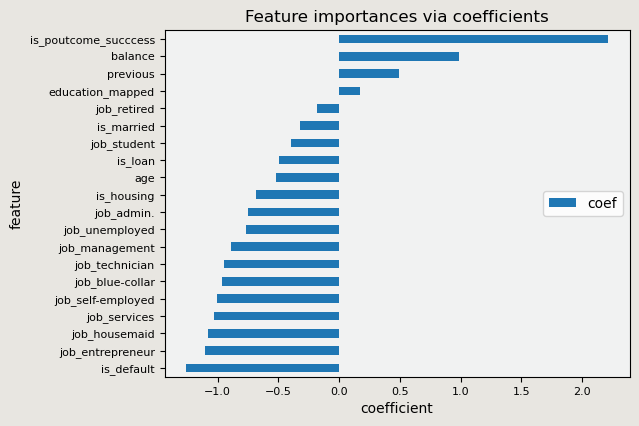

In [367]:
model = LogisticRegression()
model.fit(X_train_over, y_train_over)

importance = np.abs(model.coef_)
feature_names = np.array(X_train.columns)
plt.figure(figsize = (6, 4.5), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
pd.DataFrame(list(zip(list(X_train.columns), list(model.coef_[0]))), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)\
            .plot(x = 'feature', kind = 'barh', fontsize = 8, ax = ax)
plt.title("Feature importances via coefficients")
plt.xlabel('coefficient')
plt.legend(loc = 'center right')

Hasil perampingan 18 fitur berdasarkan cofficient hasil modeling

In [381]:
feat_imp_18 = pd.DataFrame(list(zip(list(X_train.columns), list(np.abs(model.coef_[0])))), columns = ['feature', 'coef'])\
                            .sort_values(by = ['coef'], ascending = False).reset_index(drop = True)[:18]['feature'].to_numpy()
feat_imp_18

array(['is_poutcome_succcess', 'is_default', 'job_entrepreneur',
       'job_housemaid', 'job_services', 'job_self-employed', 'balance',
       'job_blue-collar', 'job_technician', 'job_management',
       'job_unemployed', 'job_admin.', 'is_housing', 'age', 'is_loan',
       'previous', 'job_student', 'is_married'], dtype=object)

Nilai coefficient untuk setiap fitur yang telah dikonversi dan disortir secara rinci kedalam dataframe

In [370]:
pd.DataFrame(list(zip(list(X_train.columns), list(np.abs(model.coef_[0])))), columns = ['feature', 'coef'])\
                            .sort_values(by = ['coef'], ascending = False).reset_index(drop = True)

,feature,coef
0,is_poutcome_succcess,2.215788
1,is_default,1.262718
2,job_entrepreneur,1.105255
3,job_housemaid,1.076766
4,job_services,1.029277
5,job_self-employed,1.001234
6,balance,0.986398
7,job_blue-collar,0.962579
8,job_technician,0.945795
9,job_management,0.890587


Hasil pemeringkatan 18 fitur teratas menggunakan metode SelectKBest

In [379]:
from sklearn.feature_selection import SelectKBest, f_classif

k_best_18 = SelectKBest(score_func = f_classif, k = 18).fit(X_train_over, y_train_over).get_feature_names_out()
k_best_18

array(['age', 'balance', 'previous', 'is_married', 'education_mapped',
       'is_default', 'is_housing', 'is_loan', 'is_poutcome_succcess',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_services', 'job_student',
       'job_technician', 'job_unemployed'], dtype=object)

Susunan fitur hasil eliminasi features coefficient terkecil menggunakan RFE  menghasilkan 18 fitur dengan score tertinggi

In [380]:
from sklearn.feature_selection import RFE

selector = RFE(estimator = LogisticRegression(), n_features_to_select = 18, step = 1)
selector = selector.fit(X_train_over, y_train_over)
rfe_18 = selector.get_feature_names_out()
rfe_18

array(['age', 'balance', 'previous', 'is_married', 'is_default',
       'is_housing', 'is_loan', 'is_poutcome_succcess', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed'], dtype=object)

Irisan dari ketiga metode diatas diperoleh 16 fitur temporer yang akan dilakukan repetisi feature selection pada tahap berikutnya

In [382]:
features = []

for i in feat_imp_18:
    for j in k_best_18:
        for k in rfe_18:
            if (i == j) and (j == k):
                features.append(i)

np.array(features), display(len(features))

16

(array(['is_poutcome_succcess', 'is_default', 'job_entrepreneur',
        'job_housemaid', 'job_services', 'balance', 'job_blue-collar',
        'job_technician', 'job_management', 'job_unemployed', 'is_housing',
        'age', 'is_loan', 'previous', 'job_student', 'is_married'],
       dtype='<U20'),
 None)

In [452]:
X_train.columns, display(len(X_train.columns))

16

(Index(['is_poutcome_succcess', 'is_default', 'job_entrepreneur',
        'job_housemaid', 'job_services', 'balance', 'job_blue-collar',
        'job_technician', 'job_management', 'job_unemployed', 'is_housing',
        'age', 'is_loan', 'previous', 'job_student', 'is_married'],
       dtype='object'),
 None)

#### Temporal n_features = 16

In [467]:
from imblearn import over_sampling

X_train_over, y_train_over = over_sampling.SMOTE().fit_resample(X_train, y_train)

In [468]:
len(X_train_over), len(y_train_over), len(X_train), len(y_train), len(X_test), len(y_test)

(51124, 51124, 28868, 28868, 12380, 12380)

Reduksi fitur dari 20 menjadi 16 tidak menyebabkan performa model menurun secara signifikan berdasarkan hasil evaluasi berikut 

In [481]:
eval_classification()

16 Features Logistic Regression Evaluation Result
Accuracy (Train Set): 0.69
Accuracy (Test Set): 0.69
Precision (Train Set): 0.21
Precision (Test Set): 0.21
Recall (Train Set): 0.61
Recall (Test Set): 0.60
F1-Score (Train Set): 0.31
F1-Score (Test Set): 0.31

16 Features KNN Classifier Evaluation Result
Accuracy (Train Set): 0.82
Accuracy (Test Set): 0.69
Precision (Train Set): 0.38
Precision (Test Set): 0.18
Recall (Train Set): 0.89
Recall (Test Set): 0.48
F1-Score (Train Set): 0.53
F1-Score (Test Set): 0.26

16 Features Decision Tree Classifier Evaluation Result
Accuracy (Train Set): 0.99
Accuracy (Test Set): 0.80
Precision (Train Set): 1.00
Precision (Test Set): 0.20
Recall (Train Set): 0.94
Recall (Test Set): 0.26
F1-Score (Train Set): 0.97
F1-Score (Test Set): 0.23

16 Features Random Forest Classifier Evaluation Result
Accuracy (Train Set): 0.99
Accuracy (Test Set): 0.80
Precision (Train Set): 0.99
Precision (Test Set): 0.23
Recall (Train Set): 0.95
Recall (Test Set): 0.33
F1-Sc

Coefficient yang diperoleh model menggunakan 16 fitur akan dirampingkan menjadi 12 fitur dengan tingkatan tertinggi

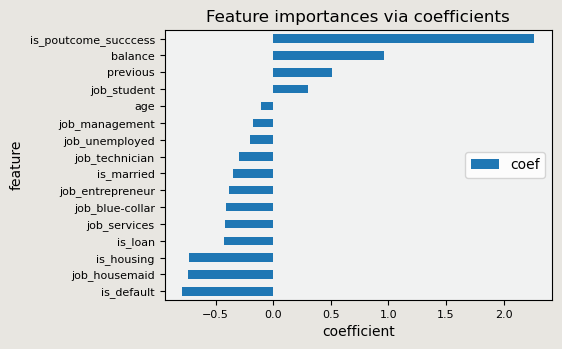

In [469]:
model = LogisticRegression()
model.fit(X_train_over, y_train_over)

importance = np.abs(model.coef_)
feature_names = np.array(X_train.columns)
plt.figure(figsize = (5, 3.5), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
pd.DataFrame(list(zip(list(X_train.columns), list(model.coef_[0]))), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)\
            .plot(x = 'feature', kind = 'barh', fontsize = 8, ax = ax)
plt.title("Feature importances via coefficients")
plt.xlabel('coefficient')
plt.legend(loc = 'center right')

Hasil perampingan 12 fitur berdasarkan cofficient hasil modeling

In [476]:
feat_imp_12 = pd.DataFrame(list(zip(list(X_train.columns), list(np.abs(model.coef_[0])))), columns = ['feature', 'coef'])\
                            .sort_values(by = ['coef'], ascending = False).reset_index(drop = True)[:12]['feature'].to_numpy()
feat_imp_12

array(['is_poutcome_succcess', 'balance', 'is_default', 'job_housemaid',
       'is_housing', 'previous', 'is_loan', 'job_services',
       'job_blue-collar', 'job_entrepreneur', 'is_married', 'job_student'],
      dtype=object)

Nilai coefficient untuk setiap fitur yang telah dikonversi dan disortir secara rinci kedalam dataframe

In [472]:
pd.DataFrame(list(zip(list(X_train.columns), list(np.abs(model.coef_[0])))), columns = ['feature', 'coef'])\
                            .sort_values(by = ['coef'], ascending = False).reset_index(drop = True)

,feature,coef
0,is_poutcome_succcess,2.268004
1,balance,0.958118
2,is_default,0.789733
3,job_housemaid,0.740749
4,is_housing,0.726436
5,previous,0.507682
6,is_loan,0.428529
7,job_services,0.419659
8,job_blue-collar,0.410823
9,job_entrepreneur,0.383170


Hasil pemeringkatan 12 fitur teratas menggunakan metode SelectKBest

In [477]:
from sklearn.feature_selection import SelectKBest, f_classif

k_best_12 = SelectKBest(score_func = f_classif, k = 12).fit(X_train_over, y_train_over).get_feature_names_out()
k_best_12

array(['is_poutcome_succcess', 'is_default', 'job_housemaid',
       'job_services', 'balance', 'job_blue-collar', 'job_management',
       'is_housing', 'is_loan', 'previous', 'job_student', 'is_married'],
      dtype=object)

Susunan fitur hasil eliminasi features coefficient terkecil menggunakan RFE menghasilkan 12 fitur dengan score tertinggi

In [478]:
from sklearn.feature_selection import RFE

selector = RFE(estimator = LogisticRegression(), n_features_to_select = 12, step = 1)
selector = selector.fit(X_train_over, y_train_over)
rfe_12 = selector.get_feature_names_out()
rfe_12

array(['is_poutcome_succcess', 'is_default', 'job_entrepreneur',
       'job_housemaid', 'job_services', 'balance', 'job_blue-collar',
       'is_housing', 'is_loan', 'previous', 'job_student', 'is_married'],
      dtype=object)

Irisan dari ketiga metode diatas diperoleh 11 fitur temporer yang akan dilakukan modeling dan evaluasi tingkat esensi dan relevansi pada tahap berikutnya

In [479]:
features = []

for i in feat_imp_12:
    for j in k_best_12:
        for k in rfe_12:
            if (i == j) and (j == k):
                features.append(i)

np.array(features), display(len(features))

11

(array(['is_poutcome_succcess', 'balance', 'is_default', 'job_housemaid',
        'is_housing', 'previous', 'is_loan', 'job_services',
        'job_blue-collar', 'is_married', 'job_student'], dtype='<U20'),
 None)

### Modeling n_features = 11

In [1125]:
X = df.drop(columns=['y']).copy()
y = df[['y']].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 9)

In [1126]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for i in list(X_train.select_dtypes(include = ['int64', 'float64']).columns):
    fitted = scaler.fit(X_train[[i]])
    X_train[i] = fitted.transform(X_train[[i]])
    X_test[i] = fitted.transform(X_test[[i]])

In [1127]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train = train[train['education'] != 'unknown']
test = test[test['education'] != 'unknown']
train = train[train['job'] != 'unknown']
test = test[test['job'] != 'unknown']

X_train = train.drop(columns=['y'])
y_train = train[['y']]

X_test = test.drop(columns=['y'])
y_test = test[['y']]

In [1128]:
X_train['is_married'] = X_train['marital'].apply(lambda x : 1 if x == 'married' else 0)

X_test['is_married'] = X_test['marital'].apply(lambda x : 1 if x == 'married' else 0)

X_train['education_mapped'] = X_train['education'].map({'primary' : 0,
                                                        'secondary' : 1,
                                                        'tertiary' : 2})

X_test['education_mapped'] = X_test['education'].map({'primary' : 0,
                                                      'secondary' : 1,
                                                      'tertiary' : 2})

X_train['is_default'] = X_train['default'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_default'] = X_test['default'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_housing'] = X_train['housing'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_housing'] = X_test['housing'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_loan'] = X_train['loan'].map({'no' : 0,
                                          'yes' : 1})

X_test['is_loan'] = X_test['loan'].map({'no' : 0,
                                        'yes' : 1})

X_train['is_poutcome_succcess'] = X_train['poutcome'].apply(lambda x : 1 if x == 'success' else 0)

X_test['is_poutcome_succcess'] = X_test['poutcome'].apply(lambda x : 1 if x == 'success' else 0)

y_train['y'] = y_train['y'].map({'no' : 0,
                                 'yes' : 1})

y_test['y'] = y_test['y'].map({'no' : 0,
                               'yes' : 1})

In [1129]:
for i in ['job']:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[i], prefix = i)], axis = 1)
    X_test = pd.concat([X_test, pd.get_dummies(X_test[i], prefix = i)], axis = 1)

In [1130]:
X_train = X_train.drop(columns = list(X_train.select_dtypes(include = ['object']).columns) +\
                       ['contact', 'day', 'month', 'duration', 'campaign', 'pdays'])
X_test = X_test.drop(columns = list(X_test.select_dtypes(include = ['object']).columns) +\
                     ['contact', 'day', 'month', 'duration', 'campaign', 'pdays'])

In [1051]:
features = ['is_poutcome_succcess', 'balance', 'is_housing', 'previous', \
            'is_loan', 'education_mapped', 'is_married']

X_train = X_train[features]
X_test = X_test[features]

In [1132]:
X_train.columns, display(len(X_train.columns))

11

(Index(['is_poutcome_succcess', 'balance', 'is_default', 'job_housemaid',
        'is_housing', 'previous', 'is_loan', 'job_services', 'job_blue-collar',
        'is_married', 'job_student'],
       dtype='object'),
 None)

Berdasarkan hasil evaluasi model dapat diketahui bahwa beberapa fitur tidak terlalu signifikan keberadaannya dalam menentukan output dari prediksi sehingga perlu direduksi menjadi 7 fitur

In [1052]:
X_train.columns, display(len(X_train.columns))

7

(Index(['is_poutcome_succcess', 'balance', 'is_housing', 'previous', 'is_loan',
        'education_mapped', 'is_married'],
       dtype='object'),
 None)

In [1053]:
from imblearn import over_sampling

X_train_over, y_train_over = over_sampling.SMOTE(random_state = 9).fit_resample(X_train, y_train)

In [1054]:
len(X_train_over), len(y_train_over), len(X_train), len(y_train), len(X_test), len(y_test)

(51174, 51174, 28879, 28879, 12369, 12369)

In [1055]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

def eval_classification():
    
    list_model = {'Logistic Regression' : LogisticRegression(random_state = 9),
                  'KNN Classifier' : KNeighborsClassifier(),
                  'Decision Tree Classifier' : DecisionTreeClassifier(random_state = 9),
                  'Random Forest Classifier' : RandomForestClassifier(random_state = 9),
                  'AdaBoost Classifier' : AdaBoostClassifier(random_state = 9),
                  'XGBoost Classifier' : XGBClassifier(random_state = 9)}
                  
    for key, val in list_model.items():
        model = val
        model.fit(X_train_over, y_train_over)
    
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba_train = model.predict_proba(X_train)

        print(key, "Evaluation Result")
        print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
        print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
        print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
        print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
        print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
        print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
        print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
        print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
        print("")

In [1056]:
eval_classification()

Logistic Regression Evaluation Result
Accuracy (Train Set): 0.69
Accuracy (Test Set): 0.69
Precision (Train Set): 0.21
Precision (Test Set): 0.21
Recall (Train Set): 0.61
Recall (Test Set): 0.60
F1-Score (Train Set): 0.31
F1-Score (Test Set): 0.31

KNN Classifier Evaluation Result
Accuracy (Train Set): 0.81
Accuracy (Test Set): 0.70
Precision (Train Set): 0.35
Precision (Test Set): 0.18
Recall (Train Set): 0.74
Recall (Test Set): 0.46
F1-Score (Train Set): 0.48
F1-Score (Test Set): 0.26

Decision Tree Classifier Evaluation Result
Accuracy (Train Set): 0.97
Accuracy (Test Set): 0.72
Precision (Train Set): 0.96
Precision (Test Set): 0.19
Recall (Train Set): 0.72
Recall (Test Set): 0.41
F1-Score (Train Set): 0.83
F1-Score (Test Set): 0.26

Random Forest Classifier Evaluation Result
Accuracy (Train Set): 0.97
Accuracy (Test Set): 0.71
Precision (Train Set): 0.88
Precision (Test Set): 0.18
Recall (Train Set): 0.81
Recall (Test Set): 0.42
F1-Score (Train Set): 0.84
F1-Score (Test Set): 0.25


In [1058]:
from sklearn.model_selection import GridSearchCV

params = {"penalty": ['l1', 'l2'],
          "C":[0.000137, 0.000142]}

model = GridSearchCV(LogisticRegression(random_state = 9), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned Logistic Regression")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'C': 0.000142, 'penalty': 'l2'}
Best Score: 0.65

Tuned Logistic Regression
Accuracy (Train Set): 0.64
Accuracy (Test Set): 0.64
Precision (Train Set): 0.19
Precision (Test Set): 0.19
Recall (Train Set): 0.66
Recall (Test Set): 0.64
F1-Score (Train Set): 0.29
F1-Score (Test Set): 0.29


In [1075]:
from sklearn.model_selection import GridSearchCV

params = {"n_neighbors": [10, 15, 20],
          "algorithm":['ball_tree', 'kd_tree', 'brute'],
          "p" : [1, 2]}

model = GridSearchCV(KNeighborsClassifier(), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned KNN Classifier")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 2}
Best Score: 0.69

Tuned KNN Classifier
Accuracy (Train Set): 0.76
Accuracy (Test Set): 0.70
Precision (Train Set): 0.28
Precision (Test Set): 0.19
Recall (Train Set): 0.70
Recall (Test Set): 0.49
F1-Score (Train Set): 0.40
F1-Score (Test Set): 0.27


In [1095]:
from sklearn.model_selection import GridSearchCV

params = {"max_depth": [1000, 2000, 3000],
          "min_samples_split":[2, 5, 10],
          "ccp_alpha" : [0.005, 0.006]}

model = GridSearchCV(DecisionTreeClassifier(random_state = 9), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned Decision Tree Classifier")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'ccp_alpha': 0.005, 'max_depth': 1000, 'min_samples_split': 2}
Best Score: 0.60

Tuned Decision Tree Classifier
Accuracy (Train Set): 0.68
Accuracy (Test Set): 0.68
Precision (Train Set): 0.20
Precision (Test Set): 0.20
Recall (Train Set): 0.60
Recall (Test Set): 0.59
F1-Score (Train Set): 0.30
F1-Score (Test Set): 0.30


In [1101]:
from sklearn.model_selection import GridSearchCV

params = {"criterion":['gini', 'entropy'],
          "ccp_alpha":[0.001, 0.008]}

model = GridSearchCV(RandomForestClassifier(random_state = 9), 
                   param_grid = params,
                   n_jobs = -1,
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned Random Forest Classifier")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'ccp_alpha': 0.001, 'criterion': 'gini'}
Best Score: 0.57

Tuned Random Forest Classifier
Accuracy (Train Set): 0.73
Accuracy (Test Set): 0.72
Precision (Train Set): 0.23
Precision (Test Set): 0.22
Recall (Train Set): 0.57
Recall (Test Set): 0.55
F1-Score (Train Set): 0.32
F1-Score (Test Set): 0.31


In [1089]:
from sklearn.model_selection import GridSearchCV

params = {"algorithm": ['SAMME', 'SAMME.R'],
          "learning_rate":[0.203, 0.217]}

model = GridSearchCV(AdaBoostClassifier(random_state = 9), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned Adaboost Classifier")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'algorithm': 'SAMME.R', 'learning_rate': 0.203}
Best Score: 0.61

Tuned Adaboost Classifier
Accuracy (Train Set): 0.69
Accuracy (Test Set): 0.68
Precision (Train Set): 0.21
Precision (Test Set): 0.21
Recall (Train Set): 0.62
Recall (Test Set): 0.60
F1-Score (Train Set): 0.31
F1-Score (Test Set): 0.31


In [1077]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01],
    'booster': ['gblinear'],
    'gamma': [0.5],
    'reg_alpha': [0, 1],
    'reg_lambda': [0.5]
}

model = GridSearchCV(XGBClassifier(random_state = 9), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned XGBoost Classifier")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

[17:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma" } are not used.

[17:02:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma" } are not used.

[17:02:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma" } are not used.

[17:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma" } are not used.

[17:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma" } are not used.

[17:02:17] WARNING: C:\bu

[17:04:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma" } are not used.



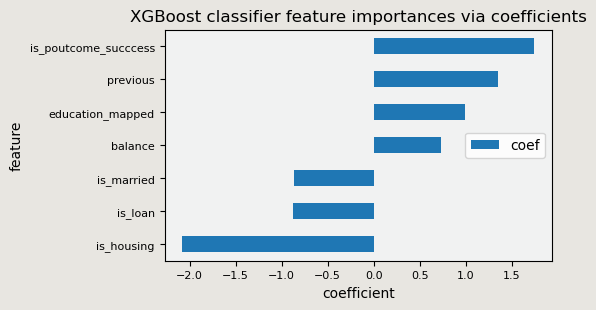

In [1078]:
model = XGBClassifier(booster = 'gblinear', gamma = 0.5, learning_rate = 0.01, n_estimators = 100,\
                      reg_alpha = 0, reg_lambda = 0.5, random_state = 9)
model.fit(X_train_over, y_train_over)
importance = np.abs(model.feature_importances_)
feature_names = np.array(X_train.columns)
plt.figure(figsize = (5, 3), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
pd.DataFrame(list(zip(list(X_train.columns), list(model.feature_importances_))), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)\
            .plot(x = 'feature', kind = 'barh', fontsize = 8, ax = ax)
plt.title("XGBoost classifier feature importances via coefficients")
plt.xlabel('coefficient')
plt.legend(loc = 'center right')

In [863]:
pd.DataFrame(list(zip(list(X_train.columns), list(model.feature_importances_))), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)

,feature,coef
0,job_services,0.005287
1,is_default,0.005308
2,job_blue-collar,0.007707
3,previous,0.010764
4,job_housemaid,0.012734
5,balance,0.014801
6,job_student,0.015884
7,is_loan,0.017525
8,is_married,0.019714
9,is_housing,0.142353


In [1061]:
pd.DataFrame(list(zip(list(X_train.columns), list(model.coef_[0]))), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)

,feature,coef
0,is_housing,-0.249110
1,is_loan,-0.106619
2,is_married,-0.100443
3,balance,0.105035
4,education_mapped,0.128424
5,previous,0.171821
6,is_poutcome_succcess,0.225070


In [1079]:
pd.DataFrame(list(zip(list(X_train.columns), list(model.feature_importances_))), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)

,feature,coef
0,is_housing,-2.080760
1,is_loan,-0.876709
2,is_married,-0.864179
3,balance,0.731104
4,education_mapped,0.991062
5,previous,1.354249
6,is_poutcome_succcess,1.745234


Text(1.9722222222222232, 0.5, 'Actual')

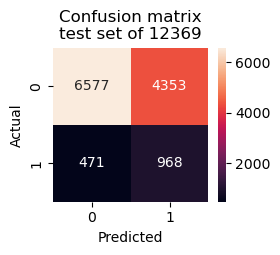

In [1080]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize = (2.5,2))
sns.heatmap((confusion_matrix(y_test, y_pred)), annot = True, fmt = '.0f', ax = fig.add_subplot(1,1, 1))
plt.title(f'Confusion matrix\ntest set of {len(y_test)}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

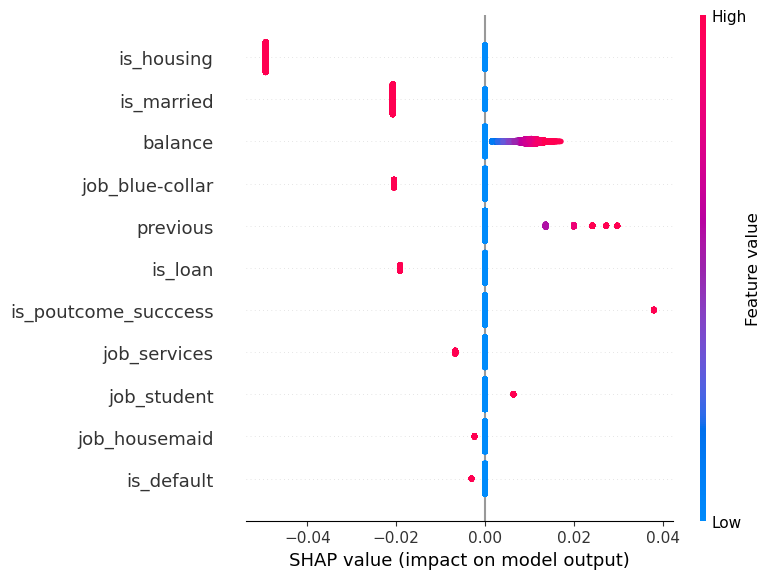

In [900]:
from xgboost import DMatrix

booster = model.get_booster()
predictions = booster.predict(DMatrix(X_test[:]), pred_contribs = True)
shap.summary_plot(predictions[:,:-1], X_test)

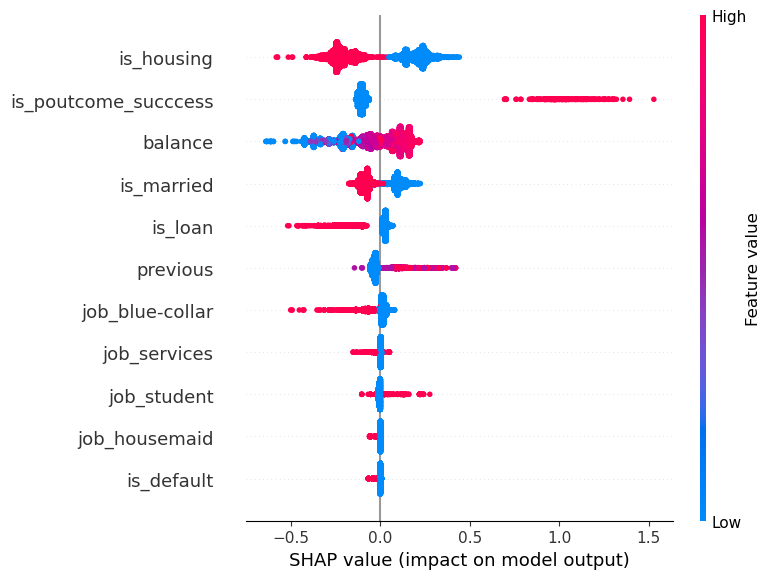

In [865]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

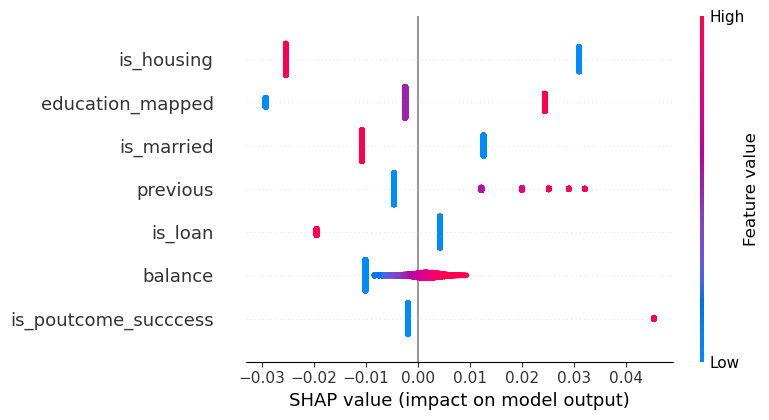

In [1082]:
explainer = shap.LinearExplainer(model, X_train_over, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = np.array(X_test)
shap.summary_plot(shap_values, X_test_array, feature_names=X_train.columns)